In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
import numpy as np
import os
import sys
import math
from PIL import Image
from pathlib import Path

#https://stackoverflow.com/questions/28013200/reading-middlebury-flow-files-with-python-bytes-array-numpy
def open_flo(flow_file):
    with open(flow_file, 'rb') as f:
        magic = np.fromfile(f, np.float32, count=1)
        if 202021.25 != magic:
            print('Magic number incorrect. Invalid .flo file')
        else:
            w = np.fromfile(f, np.int32, count=1)[0]
            h = np.fromfile(f, np.int32, count=1)[0]
            #print('Reading %d x %d flo file' % (w, h))
            data = np.fromfile(f, np.float32, count=2*w*h)
            # Reshape data into 3D array (columns, rows, bands)
            data2D = np.resize(data, (h, w, 2))
            return data2D
        
def open_image(image_file):
    return np.array(Image.open(image_file).convert('L')).astype(np.uint8)

def open_imageY(image_file):
    return np.array(Image.open(image_file))

def save_image(directory, image_file, arr):
    Path(directory).mkdir(parents=True, exist_ok=True)
    Image.fromarray(arr.astype(np.uint8)).save(directory+image_file)
    
def save_imageY(image_file, arr):
    Image.fromarray(arr).save(image_file)

#Warping by Splatting
def forward_warp(image, flow):
    newimg = np.zeros(image.shape)
    newsum = np.zeros(image.shape) + 0.0000001
    
    for i in range(image.shape[0]):
        for j in range(image.shape[1]):
            val = image[i,j]
            newj = float(j) + flow[i,j,0]
            newi = float(i) + flow[i,j,1]

            i0 = int(math.floor(newi))
            i1 = int(math.ceil(newi))
            j0 = int(math.floor(newj))
            j1 = int(math.ceil(newj))

            ax1 = newi - i0
            ay1 = newj - j0
            ax0 = 1 - ax1
            ay0 = 1 - ay1

            x0y0 = ax0 * ay0
            x1y0 = ax1 * ay0
            x0y1 = ax0 * ay1
            x1y1 = ax1 * ay1

            if j0 >= 0 and j0 < image.shape[1]:
                if i0 >= 0 and i0 < image.shape[0]:
                    newimg[i0, j0] += x0y0 * val
                    newsum[i0, j0] += x0y0
                if i1 >= 0 and i1 < image.shape[0]:
                    newimg[i1, j0] += x1y0 * val
                    newsum[i1, j0] += x1y0

            if j1 >=0 and j1 < image.shape[1]:
                if i0 >= 0 and i0 < image.shape[0]:
                    newimg[i0, j1] += x0y1 * val
                    newsum[i0, j1] += x0y1
                if i1 >= 0 and i1 < image.shape[0]:
                    newimg[i1, j1] += x1y1 * val
                    newsum[i1, j1] += x1y1
        
    
    return newimg / newsum
        

In [3]:
flow_test = open_flo("MPI-Sintel-complete/training/flow/alley_1/frame_0001.flo")
flow_test2 = open_flo("MPI-Sintel-complete/training/flow/alley_1/frame_0002.flo")
flow_test3 = open_flo("MPI-Sintel-complete/training/flow/alley_1/frame_0003.flo")
flow_test4 = open_flo("MPI-Sintel-complete/training/flow/alley_1/frame_0004.flo")
image_test = open_image("MPI-Sintel-complete/training/clean/alley_1/frame_0001.png")
image_test2 = open_image("MPI-Sintel-complete/training/clean/alley_1/frame_0002.png")
image_test3 = open_image("MPI-Sintel-complete/training/clean/alley_1/frame_0003.png")
image_test4 = open_image("MPI-Sintel-complete/training/clean/alley_1/frame_0004.png")
image_test5 = open_image("MPI-Sintel-complete/training/clean/alley_1/frame_0005.png")

In [4]:
image_warped2 = forward_warp(image_test, flow_test)
image_warped3 = forward_warp(image_warped2, flow_test2)
image_warped4 = forward_warp(image_warped3, flow_test3)
image_warped5 = forward_warp(image_warped4, flow_test4)

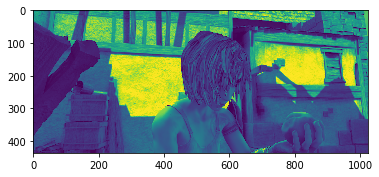

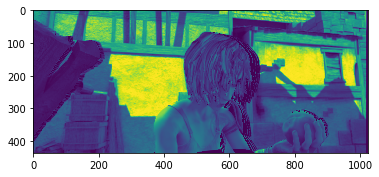

In [5]:
plt.imshow(image_test5)
plt.show()
plt.imshow(image_warped5)
plt.show()

In [35]:
def gen_Lum(img_dir, flo_dir, save_dir, idx):

    img_sets = []
    flo_sets = []

    for folder in os.listdir(img_dir):
        folder += "/"
        img_set = []
        flo_set = []
        for img_file, flo_file in zip(os.listdir(img_dir+folder), os.listdir(flo_dir+folder)):
            img_set.append((img_dir, folder, img_file))
            flo_set.append((flo_dir, folder, flo_file))
        img_sets.append(img_set)
        flo_sets.append(flo_set)
        
    
    for img_set, flo_set in zip(img_sets, flo_sets):
        for i in np.arange(len(img_set) - idx):
            img_file_link = "".join(img_set[i])
            flo_file_link = "".join(flo_set[i+idx])
            save_directory = save_dir+img_set[i][1]
            
            save_image(save_directory, img_set[i][2], open_image(img_file_link))


In [36]:
gen_Lum("data/clean/", "data/flow/", "data/clean_p0/", 0)

In [5]:
def gen_warp(img_dir, flo_dir, save_dir, idx):

    img_sets = []
    flo_sets = []

    for folder in os.listdir(img_dir):
        folder += "/"
        img_set = []
        flo_set = []
        for img_file, flo_file in zip(os.listdir(img_dir+folder), os.listdir(flo_dir+folder)):
            img_set.append((img_dir, folder, img_file))
            flo_set.append((flo_dir, folder, flo_file))
        img_sets.append(img_set)
        flo_sets.append(flo_set)
        
    ii = 0
    for img_set, flo_set in zip(img_sets, flo_sets):
        for i in np.arange(len(img_set) - idx):
            print(ii, i)
            img_file_link = "".join(img_set[i])
            flo_file_link = "".join(flo_set[i+idx])
            save_directory = save_dir+img_set[i][1]
            
            new_img = forward_warp(open_imageY(img_file_link), open_flo(flo_file_link))
            save_image(save_directory, img_set[i][2], new_img)
            
        ii += 1

In [6]:
gen_warp("data/clean_p0/", "data/flow/", "data/clean_p1/", 0)
gen_warp("data/clean_p1/", "data/flow/", "data/clean_p2/", 1)
gen_warp("data/clean_p2/", "data/flow/", "data/clean_p3/", 2)
gen_warp("data/clean_p3/", "data/flow/", "data/clean_p4/", 3)
gen_warp("data/clean_p4/", "data/flow/", "data/clean_p5/", 4)
gen_warp("data/clean_p5/", "data/flow/", "data/clean_p6/", 5)
gen_warp("data/clean_p6/", "data/flow/", "data/clean_p7/", 6)

0 0
0 1
0 2
0 3
0 4
0 5
0 6
0 7
0 8
0 9
0 10
0 11
0 12
0 13
0 14
0 15
0 16
0 17
0 18
0 19
0 20
0 21
0 22
0 23
0 24
0 25
0 26
0 27
0 28
0 29
0 30
0 31
0 32
0 33
0 34
0 35
0 36
0 37
0 38
0 39
0 40
0 41
0 42
0 43
0 44
0 45
0 46
0 47
0 48
1 0
1 1
1 2
1 3
1 4
1 5
1 6
1 7
1 8
1 9
1 10
1 11
1 12
1 13
1 14
1 15
1 16
1 17
1 18
1 19
1 20
1 21
1 22
1 23
1 24
1 25
1 26
1 27
1 28
1 29
1 30
1 31
1 32
1 33
1 34
1 35
1 36
1 37
1 38
1 39
1 40
1 41
1 42
1 43
1 44
1 45
1 46
1 47
1 48
2 0
2 1
2 2
2 3
2 4
2 5
2 6
2 7
2 8
2 9
2 10
2 11
2 12
2 13
2 14
2 15
2 16
2 17
2 18
2 19
3 0
3 1
3 2
3 3
3 4
3 5
3 6
3 7
3 8
3 9
3 10
3 11
3 12
3 13
3 14
3 15
3 16
3 17
3 18
3 19
3 20
3 21
3 22
3 23
3 24
3 25
3 26
3 27
3 28
3 29
3 30
3 31
4 0
4 1
4 2
4 3
4 4
4 5
4 6
4 7
4 8
4 9
4 10
4 11
4 12
4 13
4 14
4 15
4 16
4 17
4 18
4 19
4 20
4 21
4 22
4 23
4 24
4 25
4 26
4 27
4 28
4 29
4 30
4 31
4 32
4 33
4 34
4 35
4 36
4 37
4 38
4 39
4 40
4 41
4 42
4 43
4 44
4 45
4 46
4 47
4 48
5 0
5 1
5 2
5 3
5 4
5 5
5 6
5 7
5 8
5 9
5 10
5 11
5 12
